In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Visualising Gaussian Distributions

In [ ]:
nor_01 = torch.distributions.Normal(0, 1).sample((1,50000))
nor_12 = torch.distributions.Normal(1, 2).sample((1,50000))
# nor_01, nor_112

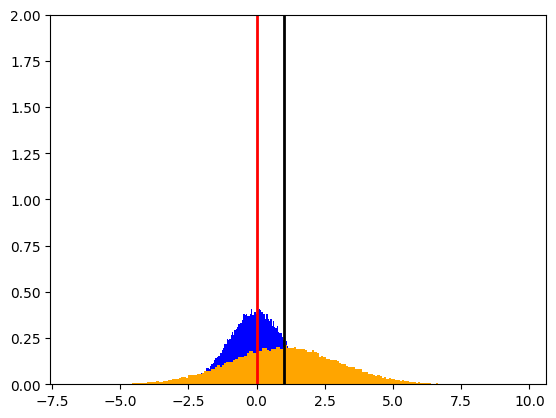

In [ ]:
# make histogram
plt.hist(nor_01[0].cpu().numpy(), density=True, bins=200, color='b')
plt.hist(nor_12[0].cpu().numpy(), density=True, bins=200, color='orange')
plt.axvline(0, color='r', linestyle='solid', linewidth=2)
plt.axvline(1, color='black', linestyle='solid', linewidth=2)
plt.ylim(0, 2)
plt.show()

You can observe a Gaussian(0,1) distribution in Blue, and the Gaussian(1,2) distribution in Orange. Red and Black are the means of the distributions.

### Loading the Data

In [ ]:
# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

batch_size = 128

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_dataset), len(test_dataset))

60000 10000


# Creating the Model

The model can take a sample distribution as input, which will be used to sample from the latent space.

For the purposes of this assignment, latent dim is locked to 2 dimensions for easy visulization. The `latent_dim` variable refers to the size of the hidden layer leading into the latent space.

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, sample_dsitrbution=torch.distributions.Normal(0, 1)):
        """
        Parameters
        ----------
        input_dim: int
            Dimensionality of the input
        hidden_dim: int
            Dimensionality of the hidden layers
        latent_dim: int
            Dimensionality of the hidden layer leading into the latent space
        sample_dsitrbution: torch.distributions
            Distribution to sample from
            (default: torch.distributions.Normal(0, 1))
        """
        super(VAE, self).__init__()

        self.epsilon = sample_dsitrbution

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean  = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        """
        Parameters
        ----------
        mean: torch.Tensor
            Mean of the distribution
        var: torch.Tensor
            Variance of the distribution
        """

        epsilon = self.epsilon.sample(var.shape).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


In [ ]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Below are some helper functions to assist with the visualization of the latent space, training of the model and creation of the loss function.

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    """
    Parameters
    ----------
    x: torch.Tensor
        Reconstructed input
    x_hat: torch.Tensor
        Original input
    mean: torch.Tensor
        Mean of the learned distribution
    log_var: torch.Tensor
        Variance of the learned distribution
    """
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [ ]:
# This function returns overall loss, this leads to the huge numbers seen after training.
def train(model, optimizer, epochs, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            # print(x.shape)
            x = x.view(-1, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss


In [ ]:
def plot_latent_space(model, scale=5.0, n=25, digit_size=28, figsize=10, center=0):
    """
    Parameters
    ----------
    model: VAE
        VAE model
    scale: float
        Scale of the latent space (Default: 5.0)
    n: int
        Number of digits to be displayed (Default: 25)
    digit_size: int
        Size of the input digits (Default: 28x28)
    figsize: int
        Size of the figure (Default: 10)
    center: float
        Center of the latent space (Default: 0)
    """

    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid
    grid_x = np.linspace(-scale+center, scale+center, n)
    grid_y = np.linspace(-scale+center, scale+center, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


# Training a model while sampling noise from Gaussian(0,1) distribution

In [ ]:
num_epochs = 40
learning_rate = 1e-3
sample_distribution = torch.distributions.Normal(0, 1)

model = VAE(input_dim=28*28, hidden_dim=400, sample_dsitrbution=sample_distribution).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
train(model, optimizer, epochs=num_epochs)


	Epoch 1 	Average Loss:  181.2076843131302
	Epoch 2 	Average Loss:  158.0296703077789
	Epoch 3 	Average Loss:  153.48338844429733
	Epoch 4 	Average Loss:  151.15278185330905
	Epoch 5 	Average Loss:  149.18744714851053
	Epoch 6 	Average Loss:  147.91238318549262
	Epoch 7 	Average Loss:  146.9000745593992
	Epoch 8 	Average Loss:  145.76009401500735
	Epoch 9 	Average Loss:  145.107114775568
	Epoch 10 	Average Loss:  144.13011728596484
	Epoch 11 	Average Loss:  143.7274379241161
	Epoch 12 	Average Loss:  142.88747593480298
	Epoch 13 	Average Loss:  142.53746645674747
	Epoch 14 	Average Loss:  141.96706750657825
	Epoch 15 	Average Loss:  141.84536187261597
	Epoch 16 	Average Loss:  141.1706013638749
	Epoch 17 	Average Loss:  140.69085303738586
	Epoch 18 	Average Loss:  140.40358152144995
	Epoch 19 	Average Loss:  140.07053274170966
	Epoch 20 	Average Loss:  139.53259885413016
	Epoch 21 	Average Loss:  139.49615843683227
	Epoch 22 	Average Loss:  139.28398981664935
	Epoch 23 	Average Loss:  

8139910.3193359375

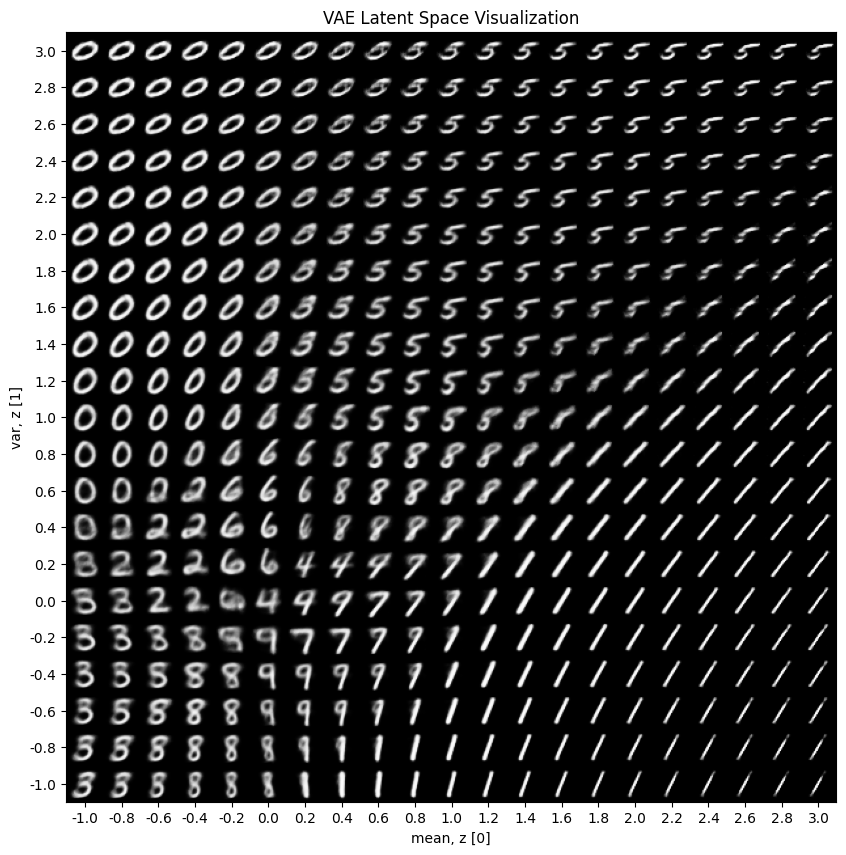

In [ ]:
plot_latent_space(model, scale=3.0, n=21, center=0)


# Training model while sampling noise from Gaussian(1,2) distribution

In [ ]:
num_epochs = 40
learning_rate = 1e-3
sample_distribution = torch.distributions.Normal(1, 2)

model_12 = VAE(input_dim=28*28, hidden_dim=400, sample_dsitrbution=sample_distribution).to(device)
optimizer = optim.Adam(model_12.parameters(), lr=learning_rate)


In [ ]:
train(model_12, optimizer, epochs=num_epochs)


	Epoch 1 	Average Loss:  179.28726082174188
	Epoch 2 	Average Loss:  158.8687391688681
	Epoch 3 	Average Loss:  154.37100086049136
	Epoch 4 	Average Loss:  151.19008334885297
	Epoch 5 	Average Loss:  148.6346079834506
	Epoch 6 	Average Loss:  146.76703821491992
	Epoch 7 	Average Loss:  145.24747227399777
	Epoch 8 	Average Loss:  144.03332125019824
	Epoch 9 	Average Loss:  143.12115886068753
	Epoch 10 	Average Loss:  142.36924676813632
	Epoch 11 	Average Loss:  141.66846616044003
	Epoch 12 	Average Loss:  140.99346560290735
	Epoch 13 	Average Loss:  140.45404034802038
	Epoch 14 	Average Loss:  140.0672310071114
	Epoch 15 	Average Loss:  139.56961020445212
	Epoch 16 	Average Loss:  139.17438921154056
	Epoch 17 	Average Loss:  138.84160481966458
	Epoch 18 	Average Loss:  138.51621652260806
	Epoch 19 	Average Loss:  138.19451883104114
	Epoch 20 	Average Loss:  137.7889251382942
	Epoch 21 	Average Loss:  137.76877965682593
	Epoch 22 	Average Loss:  137.31969114450308
	Epoch 23 	Average Loss

8034225.169921875

The latent space is centered at 1 as the distribution is Gaussian(1,2).

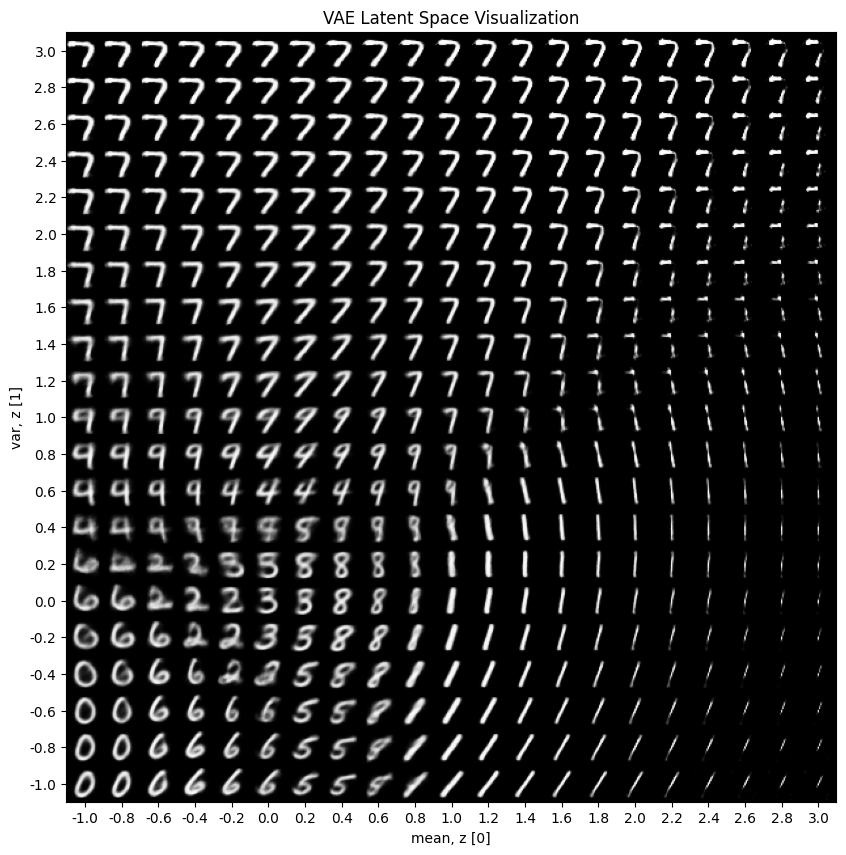

In [ ]:
plot_latent_space(model_12, scale=2.0, n=21, center=1)


# Comparing Outputs

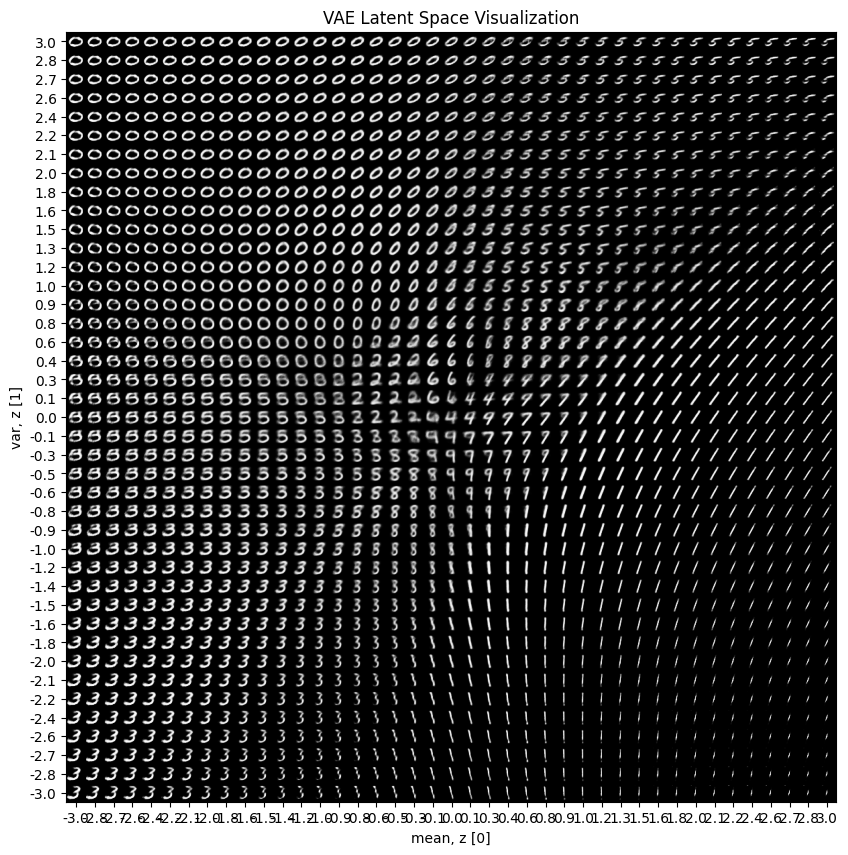

In [ ]:
plot_latent_space(model, scale=3.0, n=41, center=0, figsize=10)

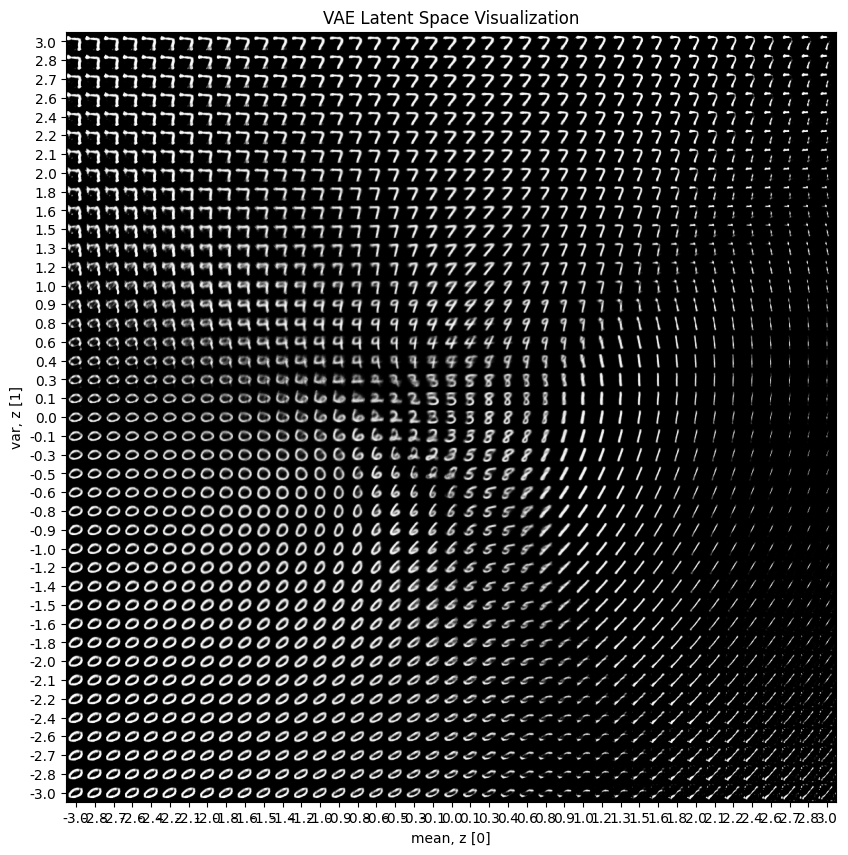

In [ ]:
plot_latent_space(model_12, scale=3.0, n=41, center=0, figsize=10)